In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Wind:
    """ relative winddirection for now as input from 0-180 on the boat looking in the heading direction
    H = [m] height of the vessel m
    B = [m] width of the vessel 
    L = [m] length of the vessel
    rel_winddir = [deg] relative winddirection from 0-180 from looking at winddirection and heading, 0 is from the head, 180 from stern ! manually
    loaded_depth = [m] depth of vessel loaded
    unloaded_depth = [m] depth of vessel unloaded
    load = 'loaded'/'unloaded', for depth and cd
    V_g = [m/s] speed over ground 
    heading = [deg] direction 0 degrees is north , 45 degrees is northeast. 
    winddirection = [deg] geographic wind direction
    U_wind = [m/s] windspeed
    rho_air = [kg/m3] density of air
    rho_water = [kg/m3] density of water
    
    - H_e: vessel height unloaded
    - H_f: vessel height loaded
    - T_e: draught unloaded
    - T_f: draught loaded
    """
    def __init__(
        #""" relative winddirection for now as input from 0-180 on the boat looking in the heading direction
        #"""
        self,
        B, 
        L,
        H ,
        rel_winddir,
        loaded_depth,
        unloaded_depth,
        load = 'loaded',
     
        V_g = [],
        heading = 40,# degrees (NE)
        winddirection = 60,# degrees (not relative but real)
        U_wind = 2,
        rho_air = 1.225,
        rho_water = 1025
        
        
        
    ):
        self.B = B
        self.L = L
        self.H = H
        self.load = load
        self.V_g = V_g
        self.heading = heading
        self.winddirection = winddirection
        self.U_wind = U_wind
        self.rho_air = rho_air
        self.rel_winddir = rel_winddir
        self.loaded_depth = loaded_depth
        self.unloaded_depth = unloaded_depth
        self.rho_water = rho_water
       
    
    def calculate_rel_winddir (self):
        #phi_w_ref = angle of attack  
        #(https://sciendo.com/pdf/10.2478/ntpe-2018-0013)
        # pffff still not found the right relations for angle, winddirection. 
        # not yet in, ook schijnbare wind niet. 
            
        self.phi_w_ref = self.winddirection - self.heading  
        return self.phi_w_ref
    
    def calculate_C_drag(self):
        # for a tanker ( ITTC: ) 
        # cda = -cx (cx given for ships)
        
        cd=[[0,0.86,0.96],[10,0.76,0.93],[20,0.62,0.85],
        [30,0.45,0.73],[40,0.32,0.62],[50,0.21,0.47],
        [60,0.13,0.34],[70,0.06,0.17],[80,0.04,0.06],
        [90,-0.02,-0.05],[100,-0.08,-0.14],[110,-0.19,-0.22],
        [120,-0.29,-0.29],[130,-0.38,-0.40],[140,-0.47,-0.53],
        [150,-0.56,-0.66],[160,-0.61,-0.75],[170,-0.66,-0.79],
        [180,-0.63,-0.77]]
    
        df=pd.DataFrame(cd,columns=['Relative wind direction','loaded','unloaded'])
    
        if self.load == 'loaded':
            self.C_drag = df['loaded'].where(df['Relative wind direction'] == self.rel_winddir).dropna().values[0]
    
        elif self.load == 'unloaded':
            self.C_drag = df['unloaded'].where(df['Relative wind direction'] == self.rel_winddir).dropna().values[0]
    
        return self.C_drag
    
    def calculate_Cd_0(self):
        if self.load == 'loaded':
            self.Cd_0 = 0.86                            
        elif self.load == 'unloaded':
            self.Cd_0 = 0.96
        return self.Cd_0 
    
    def calculate_H_above_water(self):
        if self.load == 'loaded':
            self.H_above = self.H - self.loaded_depth 
        elif self.load == 'unloaded':
            self.H_above = self.H - self.unloaded_depth
        return self.H_above
    
    def calculate_A_xv(self):
        #cubed barge assumed 
        angle=0
        if self.rel_winddir <91:
            self.A_xv = self.calculate_H_above_water() * (self.B * np.cos(self.rel_winddir*np.pi/180) + self.L * np.sin(self.rel_winddir*np.pi/180))
            self.A_ydir = self.calculate_H_above_water() * self.L * np.sin(self.rel_winddir*np.pi/180)
        elif self.rel_winddir > 90:
            angle = 90-(self.rel_winddir -90) # symmetric shape front and back. 
            self.A_xv = self.calculate_H_above_water() * (self.B * np.cos(angle*np.pi/180) + self.L * np.sin(angle*np.pi/180))
            self.A_ydir = self.calculate_H_above_water() * self.L * np.sin(angle*np.pi/180)
        return self.A_xv , angle , self.A_ydir
    
    def calculate_wind_resistance(self):
        self.R_wind = 0.5 * self.calculate_C_drag() * self.rho_air * self.calculate_A_xv()[0] * self.U_wind **2 - 0.5 * self.rho_air * self.calculate_Cd_0() * self.calculate_A_xv()[0] * self.V_g **2
    # negative value is in the Cd  value. so negative winddirection gives negative value because of cd. 
        return self.R_wind 
    
    # for the passive rudder: 
    # 1. calculate the moment caused by wind and distance to centre of gravity # assume stays constant in middle
    # 2. moment for counteraction is same, with distance to centre of gravity (assume stays constant) force fN,delta_r can be calculated. 
    # 3. depends on angle delta_R the force as well as the moment, look at different angles so that smallest angle with R is chosen
    # 4. print angle so that moment is the same.
    # 5. calculate Rrx with Rrx = abs(Fn*sin(delta_r))
    
    def calculate_moment_wind(self):
        self.wind_ydir = 0.5 * self.rho_air * self.calculate_A_xv()[2] * self.U_wind **2 * 1 
        self.mom_wind = self.wind_ydir * self.L
        # cd assumed 1, not sure if same cd as 90 deg as that is very small number.
        return self.wind_ydir , self.mom_wind
        
    def calculate_Mry(self):
        #calculate with known angle of rudder
        # ignore hull coefficient on rudeder
        
        self.dis_to_cog = self.L / 2
        lamda = 1.7 # first assumption https://marineengineeringonline.com/tag/aspect-ratio/
        A_R = 1/60 * self.B * self.L #https://www.marinesite.info/2021/05/aspect-ratio-force-acting-on-rudder.html
        self.dr = 60
        FN =   0.5 * self.rho_water * ( 6.13 * lamda/(lamda+2.25))* A_R * self.V_g **2 * np.sin(self.dr  * np.pi/180)      
        Rry = np.cos(self.dr * np.pi/180) *  FN
        Rrx = np.abs(FN*np.sin(self.dr * np.pi/180)) 
        Mry = Rry * self.dis_to_cog    

        
        return Rry, Rrx, Mry, self.dr , FN 
    
    def calculate_angle(self):
        # calculate angle of rudder and moments and resistance
        lamda = 1.7 
        A_R = 1/60 * self.B * self.L
        dr = np.arange(1,41,1)
        windmoment = self.calculate_moment_wind()[1]
        restmoment = self.calculate_Mry()[2]-windmoment
      #  if restmoment > 0:
      #      Mry = self.calculate_Mry()[2]
      #      Rrx = self.calculate_Mry()[1]
      #      angle = self.calculate_Mry()[3]
            
        #else: # restmoment<0
        Mry = 0
        angle = 0
        Rrx = 0
        while Mry < windmoment:
            angle += 1
            FN =  0.5 * self.rho_water * ( 6.13 * lamda/(lamda+2.25))* A_R * self.V_g **2 * np.sin(angle  * np.pi/180) 
            Rry = np.cos(angle * np.pi/180) *  FN
            Mry = Rry * self.L/2
            Rrx = np.abs(FN*np.sin(angle * np.pi/180))
               # if  Mry > windmoment:
               #     angle = dr[i]
               #     Rrx = np.abs(FN*np.sin(dr[i] * np.pi/180))
            if angle == 60:
                break
        
        

            
        return angle, windmoment, Mry, Rrx, restmoment

            



In [3]:
p =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1,heading = 40,winddirection = 60,U_wind =7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
print(p)

In [4]:
#print(p.calculate_FN_cosdr()[1],'H_above')
print(p.calculate_A_xv(), 'Axv')
print(p.calculate_C_drag(), 'C_drag')
print(p.calculate_rel_winddir(), 'rel_winddir')
print(p.calculate_moment_wind(), 'windmoment')

(11.688476768732555, 0, 5.730389863008699) Axv
0.76 C_drag
20 rel_winddir
(219.05059920210343, 13143.035952126205) windmoment


In [5]:
p.calculate_wind_resistance()

333.4150271181569

In [6]:
60*11/60


11.0

In [7]:

print(p.calculate_angle())
print(p.calculate_Mry())
print(p.calculate_moment_wind()[1])
print(p.calculate_angle()[4])

(2, 13143.035952126205, 15562.330443620693, 18.114951805869545, 180063.02483156562)
(6440.202026123061, 11154.757120253164, 193206.06078369182, 60, 12880.404052246118)
13143.035952126205
180063.02483156562


In [8]:
# invoegen
# stop als te veel, sensitivity analysis. 
# stappen op een rijtje zetten voor de komende tijd. 
# uitvoeren en uren maken., uren die gemaakt moeten worden zijn er al genoeg.
# met en zonder wind laten zien verschil. 
# stroming in goede richting. -> aan /  uit. 


In [9]:
## loaded, vg=0.3 m/s

U138D0 =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D10 =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D20 =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D30 =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D40=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D50 =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D60 =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D70 =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D80 =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D90=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D100 =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D110 =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D120 =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D130=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D140 =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D150 =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D160 =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D170 =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D180=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)

U107D0 =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D10 =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D20 =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D30 =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D40=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D50 =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D60 =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D70 =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D80 =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D90=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D100 =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D110 =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D120 =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D130=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D140 =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D150 =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D160 =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D170 =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D180=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)


U79D0 =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D10 =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D20 =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D30 =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D40=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D50 =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D60 =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D70 =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D80 =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D90=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D100 =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D110 =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D120 =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D130=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D140 =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D150 =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D160 =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D170 =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D180=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)

U54D0 =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D10 =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D20 =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D30 =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D40=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D50 =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D60 =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D70 =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D80 =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D90=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D100 =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D110 =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D120 =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D130=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D140 =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D150 =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D160 =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D170 =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D180=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)


U33D0 =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D10 =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D20 =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D30 =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D40=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D50 =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D60 =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D70 =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D80 =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D90=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D100 =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D110 =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D120 =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D130=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D140 =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D150 =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D160 =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D170 =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D180=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)


U15D0 =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D10 =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D20 =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D30 =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D40=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D50 =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D60 =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D70 =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D80 =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D90=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D100 =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D110 =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D120 =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D130=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D140 =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D150 =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D160 =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D170 =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D180=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)

# 4 rel wind directions
# 1 speeds , in principe vg3
# only loaded
# 6 U_wind 

# D0
# D45
# D90
# D135
# D180 

# W138 -> Bft 6
# W107 -> Bft 5
# W79 -> Bft 4
# W54 -> Bft 3
# W33 -> Bft 2
# W15 -> Bft 1





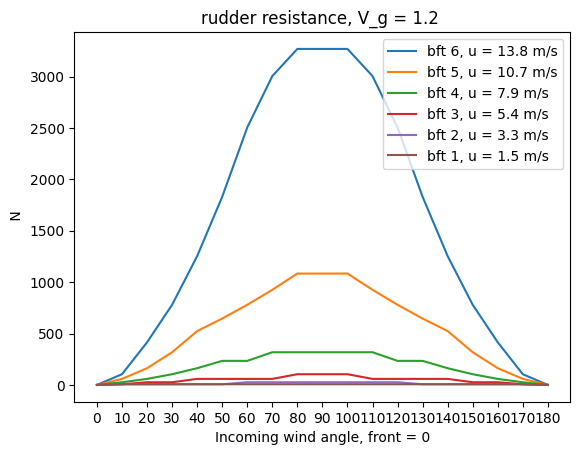

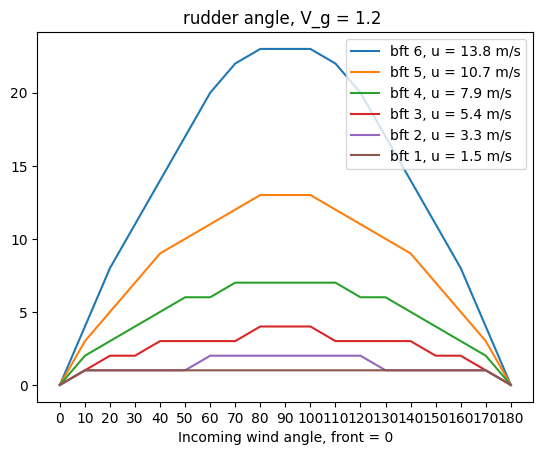

In [10]:
a0 = U138D0.calculate_angle()
a10 = U138D10.calculate_angle()
a20 = U138D20.calculate_angle()
a30 = U138D30.calculate_angle()
a40 = U138D40.calculate_angle()
a50 = U138D50.calculate_angle()
a60 = U138D60.calculate_angle()
a70 = U138D70.calculate_angle()
a80 = U138D80.calculate_angle()
a90 = U138D90.calculate_angle()
a100 = U138D100.calculate_angle()
a110 = U138D110.calculate_angle()
a120 = U138D120.calculate_angle()
a130 = U138D130.calculate_angle()
a140 = U138D140.calculate_angle()
a150 = U138D150.calculate_angle()
a160 = U138D160.calculate_angle()
a170 = U138D170.calculate_angle()
a180 = U138D180.calculate_angle()


b0 = U107D0.calculate_angle() 
b10 = U107D10.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b20 = U107D20.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b30 = U107D30.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b40 = U107D40.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b50 = U107D50.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b60 = U107D60.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b70 = U107D70.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b80 = U107D80.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b90 = U107D90.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b100 = U107D100.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b110 = U107D110.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b120 = U107D120.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b130 = U107D130.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b140 = U107D140.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b150 = U107D150.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b160 = U107D160.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b170 = U107D170.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
b180 = U107D180.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)


c0 = U79D0.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c10 = U79D10.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c20 = U79D20.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c30 = U79D30.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c40 = U79D40.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c50 = U79D50.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c60 = U79D60.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c70 = U79D70.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c80 = U79D80.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c90 = U79D90.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c100 = U79D100.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c110 = U79D110.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c120 = U79D120.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c130 = U79D130.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c140 = U79D140.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c150 = U79D150.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c160 = U79D160.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c170 = U79D170.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
c180 = U79D180.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)

d0 = U54D0.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d10 = U54D10.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d20 = U54D20.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d30 = U54D30.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d40 = U54D40.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d50 = U54D50.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d60 = U54D60.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d70 = U54D70.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d80 = U54D80.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d90 = U54D90.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d100 = U54D100.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d110 = U54D110.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d120 = U54D120.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d130 = U54D130.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d140 = U54D140.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d150 = U54D150.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d160 = U54D160.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d170 = U54D170.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
d180 = U54D180.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)


e0 = U33D0.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e10 = U33D10.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e20 = U33D20.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e30 = U33D30.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e40 = U33D40.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e50 = U33D50.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e60 = U33D60.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e70 = U33D70.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e80 = U33D80.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e90 = U33D90.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e100 = U33D100.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e110 = U33D110.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e120 = U33D120.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e130 = U33D130.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e140 = U33D140.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e150 = U33D150.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e160 = U33D160.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e170 = U33D170.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
e180 = U33D180.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)


f0 = U15D0.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f10 = U15D10.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f20 = U15D20.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f30 = U15D30.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f40 = U15D40.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f50 = U15D50.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f60 = U15D60.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f70 = U15D70.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f80 = U15D80.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f90 = U15D90.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f100 = U15D100.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f110 = U15D110.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f120 = U15D120.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f130 = U15D130.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f140 = U15D140.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f150 = U15D150.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f160 = U15D160.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f170 = U15D170.calculate_angle()# =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
f180 = U15D180.calculate_angle()#=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)


# print(a1,a2,a3,a4,a5)
# print(b1,b2,b3,b4,b5)
# print(c1,c2,c3,c4,c5)
# print(d1,d2,d3,d4,d5)
# print(e1,e2,e3,e4,e5)
# print(f1,f2,f3,f4,f5)

a = (a0[3],a10[3],a20[3],a30[3],a40[3],a50[3],a60[3],a70[3],a80[3],a90[3],a100[3],a110[3],a120[3],a130[3],a140[3],a150[3],a160[3],a170[3],a180[3])
b = (b0[3],b10[3],b20[3],b30[3],b40[3],b50[3],b60[3],b70[3],b80[3],b90[3],b100[3],b110[3],b120[3],b130[3],b140[3],b150[3],b160[3],b170[3],b180[3])
c = (c0[3],c10[3],c20[3],c30[3],c40[3],c50[3],c60[3],c70[3],c80[3],c90[3],c100[3],c110[3],c120[3],c130[3],c140[3],c150[3],c160[3],c170[3],c180[3])
d = (d0[3],d10[3],d20[3],d30[3],d40[3],d50[3],d60[3],d70[3],d80[3],d90[3],d100[3],d110[3],d120[3],d130[3],d140[3],d150[3],d160[3],d170[3],d180[3])
e = (e0[3],e10[3],e20[3],e30[3],e40[3],e50[3],e60[3],e70[3],e80[3],e90[3],e100[3],e110[3],e120[3],e130[3],e140[3],e150[3],e160[3],e170[3],e180[3])
f = (f0[3],f10[3],f20[3],f30[3],f40[3],f50[3],f60[3],f70[3],f80[3],f90[3],f100[3],f110[3],f120[3],f130[3],f140[3],f150[3],f160[3],f170[3],f180[3])

x = ['0','10','20','30','40','50','60','70','80','90','100','110','120','130','140','150','160','170','180'] 
plt.figure()

plt.plot(x,a,label = 'bft 6, u = 13.8 m/s')
plt.plot(x,b,label = 'bft 5, u = 10.7 m/s')
plt.plot(x,c,label = 'bft 4, u = 7.9 m/s')
plt.plot(x,d,label = 'bft 3, u = 5.4 m/s')
plt.plot(x,e,label = 'bft 2, u = 3.3 m/s')
plt.plot(x,f,label = 'bft 1, u = 1.5 m/s')
plt.legend()
plt.title('rudder resistance, V_g = 1.2 ')
plt.xlabel('Incoming wind angle, front = 0')
plt.ylabel(' N' )
#plt.axhline(p.calculate_Mry()[1],color = 'r')

#print(p.calculate_Mry()[1], ' N Max') 

anga = (a0[0],a10[0],a20[0],a30[0],a40[0],a50[0],a60[0],a70[0],a80[0],a90[0],a100[0],a110[0],a120[0],a130[0],a140[0],a150[0],a160[0],a170[0],a180[0])
angb = (b0[0],b10[0],b20[0],b30[0],b40[0],b50[0],b60[0],b70[0],b80[0],b90[0],b100[0],b110[0],b120[0],b130[0],b140[0],b150[0],b160[0],b170[0],b180[0])
angc = (c0[0],c10[0],c20[0],c30[0],c40[0],c50[0],c60[0],c70[0],c80[0],c90[0],c100[0],c110[0],c120[0],c130[0],c140[0],c150[0],c160[0],c170[0],c180[0])
angd = (d0[0],d10[0],d20[0],d30[0],d40[0],d50[0],d60[0],d70[0],d80[0],d90[0],d100[0],d110[0],d120[0],d130[0],d140[0],d150[0],d160[0],d170[0],d180[0])
ange = (e0[0],e10[0],e20[0],e30[0],e40[0],e50[0],e60[0],e70[0],e80[0],e90[0],e100[0],e110[0],e120[0],e130[0],e140[0],e150[0],e160[0],e170[0],e180[0])
angf = (f0[0],f10[0],f20[0],f30[0],f40[0],f50[0],f60[0],f70[0],f80[0],f90[0],f100[0],f110[0],f120[0],f130[0],f140[0],f150[0],f160[0],f170[0],f180[0])

plt.figure()
plt.title('rudder angle, V_g = 1.2 ')
plt.xlabel('Incoming wind angle, front = 0')
plt.plot(x,anga, label = 'bft 6, u = 13.8 m/s')
plt.plot(x,angb, label = 'bft 5, u = 10.7 m/s')
plt.plot(x,angc, label = 'bft 4, u = 7.9 m/s')
plt.plot(x,angd, label = 'bft 3, u = 5.4 m/s')
plt.plot(x,ange, label = 'bft 2, u = 3.3 m/s')
plt.plot(x,angf, label = 'bft 1, u = 1.5 m/s')
plt.legend()


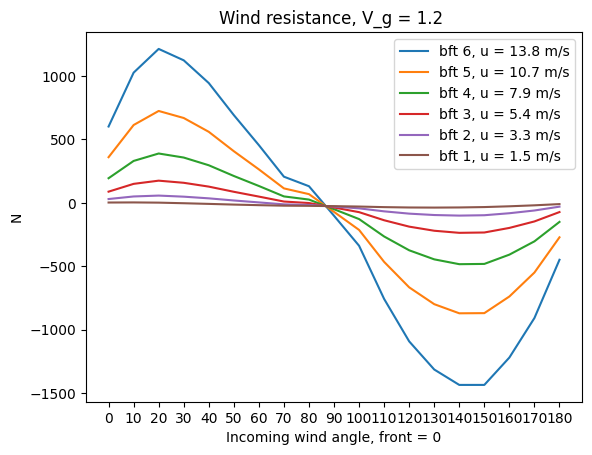

In [11]:
# wind resistance

g0 = U138D0.calculate_wind_resistance()
g10 = U138D10.calculate_wind_resistance()
g20 = U138D20.calculate_wind_resistance()
g30 = U138D30.calculate_wind_resistance()
g40 = U138D40.calculate_wind_resistance()
g50 = U138D50.calculate_wind_resistance()
g60 = U138D60.calculate_wind_resistance()
g70 = U138D70.calculate_wind_resistance()
g80 = U138D80.calculate_wind_resistance()
g90 = U138D90.calculate_wind_resistance()
g100 = U138D100.calculate_wind_resistance()
g110 = U138D110.calculate_wind_resistance()
g120 = U138D120.calculate_wind_resistance()
g130 = U138D130.calculate_wind_resistance()
g140 = U138D140.calculate_wind_resistance()
g150 = U138D150.calculate_wind_resistance()
g160 = U138D160.calculate_wind_resistance()
g170 = U138D170.calculate_wind_resistance()
g180 = U138D180.calculate_wind_resistance()


h0 = U107D0.calculate_wind_resistance() 
h10 = U107D10.calculate_wind_resistance()
h20 = U107D20.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h30 = U107D30.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h40 = U107D40.calculate_wind_resistance()#=  Wind(h = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h50 = U107D50.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h60 = U107D60.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h70 = U107D70.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h80 = U107D80.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h90 = U107D90.calculate_wind_resistance()#=  Wind(h = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h100 = U107D100.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h110 = U107D110.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h120 = U107D120.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h130 = U107D130.calculate_wind_resistance()#=  Wind(h = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h140 = U107D140.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h150 = U107D150.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h160 = U107D160.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h170 = U107D170.calculate_wind_resistance()# =  Wind(h = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
h180 = U107D180.calculate_wind_resistance()#=  Wind(h = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)


i0 = U79D0.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i10 = U79D10.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i20 = U79D20.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i30 = U79D30.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i40 = U79D40.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i50 = U79D50.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i60 = U79D60.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i70 = U79D70.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i80 = U79D80.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i90 = U79D90.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i100 = U79D100.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i110 = U79D110.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i120 = U79D120.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i130 = U79D130.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i140 = U79D140.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i150 = U79D150.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i160 = U79D160.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i170 = U79D170.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
i180 = U79D180.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)

j0 = U54D0.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j10 = U54D10.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j20 = U54D20.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j30 = U54D30.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j40 = U54D40.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j50 = U54D50.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j60 = U54D60.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j70 = U54D70.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j80 = U54D80.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j90 = U54D90.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j100 = U54D100.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j110 = U54D110.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j120 = U54D120.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j130 = U54D130.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j140 = U54D140.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j150 = U54D150.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j160 = U54D160.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j170 = U54D170.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
j180 = U54D180.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)


k0 = U33D0.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k10 = U33D10.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k20 = U33D20.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k30 = U33D30.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k40 = U33D40.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k50 = U33D50.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k60 = U33D60.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k70 = U33D70.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k80 = U33D80.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k90 = U33D90.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k100 = U33D100.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k110 = U33D110.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k120 = U33D120.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k130 = U33D130.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k140 = U33D140.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k150 = U33D150.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k160 = U33D160.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k170 = U33D170.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
k180 = U33D180.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)


l0 = U15D0.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l10 = U15D10.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=10,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l20 = U15D20.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l30 = U15D30.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=30,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l40 = U15D40.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l50 = U15D50.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=50,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l60 = U15D60.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=60,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l70 = U15D70.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=70,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l80 = U15D80.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=80,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l90 = U15D90.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l100 = U15D100.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=100,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l110 = U15D110.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=110,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l120 = U15D120.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=120,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l130 = U15D130.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l140 = U15D140.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=140,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l150 = U15D150.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=150,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l160 = U15D160.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=160,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l170 = U15D170.calculate_wind_resistance()# =  Wind(B = 11,L = 60,rel_winddir=170,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
l180 = U15D180.calculate_wind_resistance()#=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 1.2,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)

g = (g0,g10,g20,g30,g40,g50,g60,g70,g80,g90,g100,g110,g120,g130,g140,g150,g160,g170,g180)
h = (h0,h10,h20,h30,h40,h50,h60,h70,h80,h90,h100,h110,h120,h130,h140,h150,h160,h170,h180)
i = (i0,i10,i20,i30,i40,i50,i60,i70,i80,i90,i100,i110,i120,i130,i140,i150,i160,i170,i180)
j = (j0,j10,j20,j30,j40,j50,j60,j70,j80,j90,j100,j110,j120,j130,j140,j150,j160,j170,j180)
k = (k0,k10,k20,k30,k40,k50,k60,k70,k80,k90,k100,k110,k120,k130,k140,k150,k160,k170,k180)
l = (l0,l10,l20,l30,l40,l50,l60,l70,l80,l90,l100,l110,l120,l130,l140,l150,l160,l170,l180)

x = ['0','10','20','30','40','50','60','70','80','90','100','110','120','130','140','150','160','170','180'] 
plt.figure()

plt.plot(x,g, label = 'bft 6, u = 13.8 m/s')
plt.plot(x,h, label = 'bft 5, u = 10.7 m/s')
plt.plot(x,i, label = 'bft 4, u = 7.9 m/s')
plt.plot(x,j, label = 'bft 3, u = 5.4 m/s')
plt.plot(x,k, label = 'bft 2, u = 3.3 m/s')
plt.plot(x,l, label = 'bft 1, u = 1.5 m/s')
plt.ylabel('N')
plt.xlabel('Incoming wind angle, front = 0')
plt.title('Wind resistance, V_g = 1.2 ')
plt.legend()

In [12]:
# daar gaat het mis, is logisch.. Even tijdelijke oplossing voor zoeken. 
# d40 van maken, 45 staat niet in cd lijst. 

In [13]:
# resistance parts. laten zien. loaded/unloaded -> daar ook berekeningetje voor maken. Laten zien met wind dat het niet te doen is fully unloaded.
# omgebouwde schepen gaat het om. 
# precieze plek moet meer naar gekeken worden. 
# pijplediing moet verder naar gekeken worden. 
# cycle definieren als lijn voor wat ik als uitvalsbasis neem en welke aannames daarin zitten. Met plaatjes. 
# kijken naar feedback jan op vorige. 
# ook relatieve invloed in vergelijking met andere resistances laten zien. 
# sensitivity ook laten zien wat de minimale snelheid is zodat dit niet gebeurt. -> voor loaded en dan paar verschillende snelheden. Moet minstens 60 graden kunnen varen bijv. 
# wat meer punten toevoegen misschien. 
# wat voorbeeldjes laten zien ook. van dat het klopt. 
# wat als met stroom mee?,, dan helemaal geen snelheid?/
# ignore vaartwind door stroming. 
# Dit voor aantal snelheden. 
# meer punten , alle punten per 10 , 0-180? -> loopen. 
# 2 snelehden. 
# kritieke regionen bepalen voor rudder.
# kan ook meerdere snelheden voor de punten buiten de region die werkt. -> wanneer erbuiten. 
# alle gedeeltes duidelijk opschrijven met formules en aannames. 
# als met stroom mee? dan helemaal niet corrigeren. 
# golven -> +/- met richtingen van compenseren. 
# relatieve grootte laten zien alle resistances, -> dat met man produceren, kijken wat er niet lukt komende maandag. 
# dus moet morgen. 
# loaded / unloaded

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[602.3122874999999, 1131.5304545425354, 1629.3522498861782, 1904.3712174822076, 2198.6132941820915, 2523.126164835611, 2960.5903834708647, 3211.886916907159, 3400.856801538012, 3167.7547175829154, 2931.2568599426654, 2247.2637781689205, 1412.2965372862325, 515.7541419645538, -183.12536952314304, -656.7743658615925, -805.6390436176757, -804.4926158570679, -449.17955774999996]


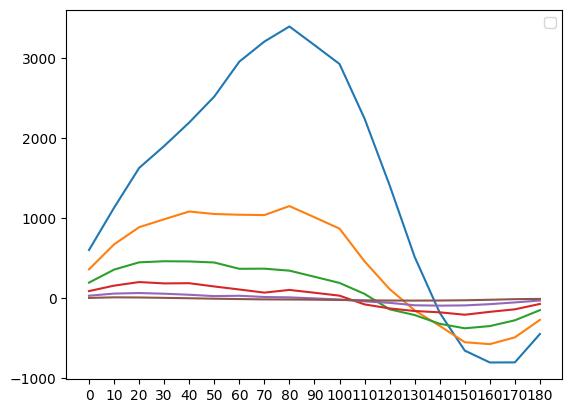

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\NLFLKO\Anaconda3\envs\sim3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\NLFLKO\Anaconda3\envs\sim3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] De externe host heeft een verbinding verbroken
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\NLFLKO\Anaconda3\envs\sim3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\NLFLKO\Anaconda3\envs\sim3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] De externe host

In [14]:
# total added resistance
m = [a[i] + g[i] for i in range(len(a))]
n = [b[i] + h[i] for i in range(len(b))]
o = [c[j] + i[j] for j in range(len(c))]
p = [d[i] + j[i] for i in range(len(d))]
q = [e[i] + k[i] for i in range(len(e))]
r = [f[i] + l[i] for i in range(len(a))]
print(m)
x = ['0','10','20','30','40','50','60','70','80','90','100','110','120','130','140','150','160','170','180'] 
plt.figure()
plt.legend()
plt.plot(x,m)
plt.plot(x,n)
plt.plot(x,o)
plt.plot(x,p)
plt.plot(x,q)
plt.plot(x,r)

# verschillende kleuren is verschillende u_ wind.
#Als meer stappen dan wordt het gezeik met letters.. 